In [211]:
import numpy as np
import random
import torch
torch.set_default_dtype(torch.float64)
from scipy.sparse.linalg import LinearOperator
from scipy.special import softmax
import numpy as np
import matplotlib.pyplot as plt

Tout d'abord on crée la fonction

In [274]:


class Problem:
    def __init__(self, U, V, mu, nu, q, epsilon):
        self.U = U  # (nb_receivers, nb_states, nb_actions)
        self.V = V  # (nb_states, nb_actions)
        self.mu = mu  # (nb_states,)
        self.nu = nu  # (nb_receivers, nb_states)
        self.q = q  # (nb_receivers, nb_messages, nb_actions)
        self.epsilon = epsilon  # (nb_receivers,)
        self.nb_receivers, self.nb_states, self.nb_actions = U.shape
        self.nb_messages = q.shape[1]
        self.size = self.nb_receivers * self.nb_states * self.nb_messages
        self.shape = (self.nb_receivers, self.nb_states, self.nb_messages)
        self.check()

    def check(self):
        for receiver_idx in range(self.nb_receivers):
            self.debug_shape(self.U[receiver_idx], [self.nb_states, self.nb_actions])
            self.debug_shape(self.V, [self.nb_states, self.nb_actions])
            self.debug_shape(self.mu, [self.nb_states])
            self.debug_shape(self.nu[receiver_idx], [self.nb_states])
            self.debug_shape(self.q[receiver_idx], [self.nb_messages, self.nb_actions])

    def debug_shape(self, vect, target_shape):
        if list(vect.shape) != target_shape:
            print(f"Found vector of size {vect.shape}, expected {target_shape}")
            assert False

    def verbose(self, pi):
        print(f"We have (state, message, action) = ({self.nb_states}, {self.nb_messages}, {self.nb_actions})")
        self.debug_shape(pi, [self.nb_states, self.nb_messages])
        for receiver_idx in range(self.nb_receivers):
            theta = self.compute_theta(self.compute_g(pi, receiver_idx), receiver_idx)
            self.debug_shape(theta, [self.nb_messages, self.nb_actions])
            print(f"We have 1 = {pi.sum(axis=1)}")
            print(f"We have 1 = {theta.sum(axis=1)}")
            print("Theta", theta)
        print("Objective", self.objective(pi, range(self.nb_receivers)))

    def compute_g(self, pi, receiver_idx):
        denominator = (pi * self.nu[receiver_idx][:, None]).sum(axis=0)
        self.debug_shape(denominator, [self.nb_messages])
        g = (pi[:, :, None] * self.nu[receiver_idx][:, None, None] * self.U[receiver_idx][:, None, :]).sum(axis=0)
        self.debug_shape(g, [self.nb_messages, self.nb_actions])
        return g / denominator[:, None]

    def compute_theta(self, g, receiver_idx):
        max_g, _ = g.max(axis=1)
        exp = torch.exp((g - max_g[:, None]) / self.epsilon[receiver_idx])
        self.debug_shape(exp, [self.nb_messages, self.nb_actions])
        theta = self.q[receiver_idx] * exp
        denom = theta.sum(axis=1)
        return theta / denom[:, None]

    def objective(self, pi, receivers_batch):
        total_objective = 0
        for receiver_idx in receivers_batch:
            g = self.compute_g(pi, receiver_idx)
            theta = self.compute_theta(g, receiver_idx)
            total_objective += (theta[None, :, :] * pi[:, :, None] * self.mu[:, None, None] * self.V[:, None, :]).sum()
        return total_objective / len(receivers_batch)

    def value(self, x, receivers_batch=None):
        if receivers_batch is None:
            receivers_batch = range(self.nb_receivers)
        x = x.reshape(self.nb_states, self.nb_messages)
        x = torch.from_numpy(x).requires_grad_(True)
        f = self.objective(x, receivers_batch)
        f.backward()
        df = x.grad
        return -f.item(), -df.numpy()

    def project(self, x):
        x = torch.from_numpy(x).reshape(self.nb_states, self.nb_messages)
        x_projected = torch.zeros_like(x)
        for i in range(x.shape[0]):
            row = x[i, :]
            sorted_row, _ = torch.sort(row, descending=True)
            cumulative_sum = torch.cumsum(sorted_row, dim=0)
            rho = torch.nonzero(sorted_row * torch.arange(1, len(row) + 1) > (cumulative_sum - 1), as_tuple=False).max()
            theta = (cumulative_sum[rho] - 1) / (rho + 1)
            x_projected[i, :] = torch.clamp(row - theta, min=0)
        return x_projected.numpy()

    def project_tangent(self, x, d):
        d2 = d - d.mean(axis=1)[:, None]
        d2[(x == 0) * (d2 < 0)] = 0.
        d2[(x == 1) * (d2 > 0)] = 0.
        return d2


In [275]:


def dot(a, b):
    return (a * b).sum()

def ls_wolfe(x, function, step, descent, f, df, batch):
    """
    Wolfe line search for stochastic gradient descent.
    """
    step_min, step_max = 0., np.inf
    scal = dot(df, descent)
    if scal > 0:
        print('WARNING with scal', scal)
    step2 = step
    eps1, eps2 = 1.e-4, 0.9  # Wolfe condition parameters
    i = 0
    while i < 100:
        i += 1
        x2 = function.project(x + step2 * descent)
        f2, df2 = function.value(x2, batch)
        if dot(x2 - x, df) >= 0:
            print('We have a problem', dot(x2 - x, df), dot(descent, df))
        if f2 > f + eps1 * dot(x2 - x, df):  # step is too big, decrease it
            step_max = step2
            step2 = 0.5 * (step_min + step_max)
        else:
            if dot(df2, x2 - x) < eps2 * dot(df, x2 - x):  # step is too small, increase it
                step_min = step2
                step2 = min(0.5 * (step_min + step_max), 2 * step_min)
            else:
                return x2, f2, df2, step2
    print('We do not exit Wolfe')
    return x2, f2, df2, step2


def dot(a,b) :
    return (a*b).sum()

def ls_wolfe(x,function,step,descent,f,df,batch) :
    step_min,step_max=0.,np.inf
    scal=dot(df,descent)
    if scal > 0 :
        print('WARNING with scal',scal)
    step2=step
    eps1,eps2=1.e-4,0.9
    i=0
    while i<100 :
        i=i+1
        x2=function.project(x+step2*descent)
        f2,df2=function.value(x2,batch)
        if dot(x2-x,df) >=0 :
            print('We have a problem',dot(x2-x,df),dot(descent,df))
        if f2>f+eps1*dot(x2-x,df) : # step is too big, decrease it
            step_max=step2
            step2=0.5*(step_min+step_max)
        else :
            if dot(df2,x2-x) < eps2*dot(df,x2-x) : # step is too small, increase it
                step_min=step2
                step2=min(0.5*(step_min+step_max),2*step_min)
            else :
                return x2,f2,df2,step2
    print('We do not exit Wolfe')
    print(f2>f+eps1*step2*scal,dot(df2,descent) < eps2*scal)
    return x2,f2,df2,step2




def optimize(function,itermax = 5000,tol=1.e-4,batch_size = 100,verbose=True):
    np.random.seed(42)
    receivers = list(range(function.nb_receivers))
    x = np.random.randn(function.nb_states, function.nb_messages)
    x=function.project(x)
    np.random.seed(None)
    list_costs=[]
    list_grads=[]
    nbiter = 0
    batch = np.random.choice(receivers, size=batch_size, replace=False)
    f,df=function.value(x,batch)
    df_tangent=function.project_tangent(x,-df)
    norm_grad=np.linalg.norm(df_tangent)
    err=2*tol
    if verbose :
        print('iter={:4d} f={:1.3e} df={:1.3e}'.format(nbiter,f,err))
    list_costs.append(f)
    list_grads.append(norm_grad)
    while (err > tol) and (nbiter < itermax):
        descent=-df
        x_old=np.copy(x)
        x,f,df,step = ls_wolfe(x, function,1., descent,f,df,batch)
        batch = np.random.choice(receivers, size=batch_size, replace=False)
        norm_grad = np.linalg.norm(function.project_tangent(x,-df))
        list_costs.append(f)
        list_grads.append(norm_grad)
        err=norm_grad
        nbiter+=1
        if verbose :
            print('iter={:4d} f={:1.3e} err={:1.3e} s={:1.3e}'.format(nbiter,f,err,step))
        if (err <= tol):
            if verbose : print("Success !!! Algorithm converged !!!")
            return x,list_costs,list_grads
    if verbose : print("FAILED to converge")


def stochastic_optimize(function,itermax = 5000,tol=1.e-5,batch_size = 100,verbose=True):
    np.random.seed(42)
    receivers = list(range(function.nb_receivers))
    x = np.random.randn(function.nb_states, function.nb_messages)
    x=function.project(x)
    np.random.seed(None)
    list_costs=[]
    list_grads=[]
    nbiter = 0
    batch = np.random.choice(receivers, size=batch_size, replace=False)
    f,df=function.value(x,batch)
    df_tangent=function.project_tangent(x,-df)
    norm_grad=np.linalg.norm(df_tangent)
    err=2*tol
    if verbose :
        print('iter={:4d} f={:1.3e} df={:1.3e}'.format(nbiter,f,err))
    list_costs.append(f)
    list_grads.append(norm_grad)
    while (err > tol) and (nbiter < itermax):
        nbiter+=1
        x_old=np.copy(x)
        batch = np.random.choice(receivers, size=batch_size, replace=False)
        x = function.project(x - ( 0.01 ) * df)
        f,df = function.value(x,batch)
        norm_grad = np.linalg.norm(function.project_tangent(x,-df))
        list_costs.append(f)
        list_grads.append(norm_grad)
        err=norm_grad
        if verbose :
            print('iter={:4d} f={:1.3e} err={:1.3e}'.format(nbiter,f,err))
        if (err <= tol):
            if verbose : print("Success !!! Algorithm converged !!!")
            return x,list_costs,list_grads
    if verbose : print("FAILED to converge")


def stochastic_optimize_epochs(function, max_epochs=20, batch_size=100, verbose=True,seed=None):
    import numpy as np

    np.random.seed(42)
    receivers = list(range(function.nb_receivers))
    x = np.random.randn(function.nb_states, function.nb_messages)
    x = function.project(x)
    np.random.seed(seed)

    list_costs = []
    list_grads = []

    for epoch in range(max_epochs):
        # Shuffle the dataset
        np.random.shuffle(receivers)
        total_batches = len(receivers) // batch_size

        for batch_idx in range(total_batches):
            batch = receivers[batch_idx * batch_size:(batch_idx + 1) * batch_size]
            f, df = function.value(x, batch)
            df_tangent = function.project_tangent(x, -df)
            x = function.project(x - 0.001 * df)

        # At the end of the epoch, calculate f and gradient for the full dataset
        f, df = function.value(x, receivers)
        norm_grad = np.linalg.norm(function.project_tangent(x, -df))

        list_costs.append(f)
        list_grads.append(norm_grad)

        if verbose:
            print(f"Epoch {epoch + 1}/{max_epochs} - f: {f:.3e} - grad_norm: {norm_grad:.3e}")


    return x, list_costs, list_grads



On crée 1000 variations d'un receiver de base

In [276]:
alpha = 0.7
beta = 0.9

# Initialisation des matrices de base
nb_receivers = 1000
nb_states = 2
nb_actions = 2
nb_messages = 2

U_base = torch.tensor([[1.0, 0.0], [0.0, 1.0]], dtype=torch.float64)  # Matrice U de base
nu_base = torch.tensor([alpha, 1 - alpha], dtype=torch.float64)  # Distribution de probabilité de base pour nu
q_base = torch.tensor([beta, 1 - beta], dtype=torch.float64)  # Une seule ligne pour q de base
epsilon_base = 1e-2  # Valeur de base pour epsilon

mu = torch.tensor([alpha, 1 - alpha])

# Fonction pour ajouter du bruit à une matrice tout en conservant les propriétés des distributions
def add_noise_to_distribution(base_vector, noise_level):
    noisy_vector = base_vector + noise_level * torch.randn_like(base_vector)
    noisy_vector = torch.clamp(noisy_vector, min=1e-8)  # Évite les valeurs négatives
    return noisy_vector / noisy_vector.sum()  # Normalisation pour conserver les distributions


def add_noise_to_distribution(base_vector, noise_level):
    noise = noise_level * torch.randn(1, dtype=base_vector.dtype)
    
    # Application du bruit au vecteur
    noisy_vector = base_vector + noise
    
    # Normalisation avec softmax(log(...))
    normalized_vector = torch.softmax(torch.log(noisy_vector), dim=-1)
    
    return normalized_vector




# Génération des variations
noise_level_U = 0.1
noise_level_nu = 0.05
noise_level_q = 0.01
noise_level_epsilon = 0.01

torch.manual_seed(42)
np.random.seed(42)

U = torch.stack([U_base + noise_level_U * torch.randn_like(U_base) for _ in range(nb_receivers)])
nu = torch.stack([add_noise_to_distribution(nu_base, noise_level_nu) for _ in range(nb_receivers)])
q = torch.stack([add_noise_to_distribution(q_base, noise_level_q).expand(nb_messages, -1) for _ in range(nb_receivers)])
epsilon = torch.tensor([epsilon_base + noise_level_epsilon * np.random.randn() for _ in range(nb_receivers)])
epsilon = torch.clamp(epsilon, min=1e-8)  # Assurez-vous que epsilon reste positif

# Vérifications
print("Exemple de U :", U[0])
print("Exemple de nu (somme = 1) :", nu[0], "Somme =", nu[0].sum())
print("Exemple de q (lignes identiques, somme = 1) :", q[0], "Somme des lignes =", q[0].sum(dim=1))
print("Exemple de epsilon :", epsilon[:10])

V = torch.tensor([[0.0, 1.0],
                  [0.0, 1.0]])

Exemple de U : tensor([[1.0337, 0.0129],
        [0.0234, 1.0230]])
Exemple de nu (somme = 1) : tensor([0.7261, 0.2739]) Somme = tensor(1.0000)
Exemple de q (lignes identiques, somme = 1) : tensor([[0.8946, 0.1054],
        [0.8946, 0.1054]]) Somme des lignes = tensor([1., 1.])
Exemple de epsilon : tensor([0.0150, 0.0086, 0.0165, 0.0252, 0.0077, 0.0077, 0.0258, 0.0177, 0.0053,
        0.0154])


On optimise la "vraie" fonction (moyenne sur tous les Receivers) pour comparer ensuite avec l'optimisation sur des batchs

In [277]:
# Création de l'objet Problem avec les données générées
P = Problem(U, V, mu, nu, q, epsilon)

#x,costs,grad=stochastic_optimize(P,tol=1.e-5,verbose=True,batch_size = 1000)

In [278]:
x0,costs,grad = optimize(P,batch_size = 1000)

iter=   0 f=-4.076e-01 df=2.000e-04
iter=   1 f=-4.575e-01 err=3.221e-01 s=2.500e-01
iter=   2 f=-4.627e-01 err=3.654e-01 s=1.000e+00
iter=   3 f=-4.682e-01 err=1.041e-01 s=1.250e-01
iter=   4 f=-4.689e-01 err=1.375e-02 s=2.500e-01
iter=   5 f=-4.690e-01 err=5.936e-02 s=1.000e+00
iter=   6 f=-4.691e-01 err=5.121e-02 s=4.204e-02
iter=   7 f=-4.691e-01 err=1.217e-02 s=4.768e-07
iter=   8 f=-4.691e-01 err=1.730e-03 s=2.384e-07
iter=   9 f=-4.691e-01 err=4.902e-04 s=2.384e-07
iter=  10 f=-4.691e-01 err=1.300e-04 s=2.384e-07
iter=  11 f=-4.691e-01 err=1.998e-04 s=4.768e-07
iter=  12 f=-4.691e-01 err=7.331e-05 s=1.192e-07
Success !!! Algorithm converged !!!


In [279]:
true_max = -costs[-1]

true_max

0.469145944184483

In [280]:
x1,costs1,grad1=stochastic_optimize_epochs(P,batch_size = 10,seed=42)

Epoch 1/20 - f: -4.318e-01 - grad_norm: 4.451e-01
Epoch 2/20 - f: -4.471e-01 - grad_norm: 4.248e-01
Epoch 3/20 - f: -4.620e-01 - grad_norm: 3.399e-01
Epoch 4/20 - f: -4.683e-01 - grad_norm: 8.427e-02
Epoch 5/20 - f: -4.686e-01 - grad_norm: 5.372e-02
Epoch 6/20 - f: -4.691e-01 - grad_norm: 5.861e-02
Epoch 7/20 - f: -4.688e-01 - grad_norm: 3.728e-02
Epoch 8/20 - f: -4.689e-01 - grad_norm: 2.127e-02
Epoch 9/20 - f: -4.690e-01 - grad_norm: 6.251e-03
Epoch 10/20 - f: -4.689e-01 - grad_norm: 1.367e-02
Epoch 11/20 - f: -4.690e-01 - grad_norm: 6.486e-04
Epoch 12/20 - f: -4.689e-01 - grad_norm: 1.218e-02
Epoch 13/20 - f: -4.690e-01 - grad_norm: 7.507e-03
Epoch 14/20 - f: -4.690e-01 - grad_norm: 5.866e-03
Epoch 15/20 - f: -4.690e-01 - grad_norm: 2.698e-03
Epoch 16/20 - f: -4.690e-01 - grad_norm: 9.820e-04
Epoch 17/20 - f: -4.690e-01 - grad_norm: 1.041e-02
Epoch 18/20 - f: -4.689e-01 - grad_norm: 1.496e-02
Epoch 19/20 - f: -4.690e-01 - grad_norm: 1.018e-02
Epoch 20/20 - f: -4.690e-01 - grad_norm:

In [281]:
costs1 = -np.array(costs1)
costs1

array([0.43184887, 0.44712596, 0.46204373, 0.46831805, 0.46859871,
       0.46906003, 0.46884365, 0.46892477, 0.46895473, 0.46894464,
       0.46895718, 0.46894735, 0.46895361, 0.46895504, 0.46895675,
       0.46895714, 0.46895012, 0.46894536, 0.4689515 , 0.46895648])

In [282]:
x2,costs2,grad2=stochastic_optimize_epochs(P,batch_size = 20,seed=43)

Epoch 1/20 - f: -4.203e-01 - grad_norm: 4.961e-01
Epoch 2/20 - f: -4.315e-01 - grad_norm: 4.530e-01
Epoch 3/20 - f: -4.401e-01 - grad_norm: 4.280e-01
Epoch 4/20 - f: -4.491e-01 - grad_norm: 4.100e-01
Epoch 5/20 - f: -4.567e-01 - grad_norm: 3.513e-01
Epoch 6/20 - f: -4.624e-01 - grad_norm: 3.328e-01
Epoch 7/20 - f: -4.679e-01 - grad_norm: 3.283e-01
Epoch 8/20 - f: -4.685e-01 - grad_norm: 8.715e-02
Epoch 9/20 - f: -4.683e-01 - grad_norm: 9.885e-02
Epoch 10/20 - f: -4.686e-01 - grad_norm: 5.072e-02
Epoch 11/20 - f: -4.688e-01 - grad_norm: 4.960e-02
Epoch 12/20 - f: -4.690e-01 - grad_norm: 5.900e-02
Epoch 13/20 - f: -4.691e-01 - grad_norm: 5.682e-02
Epoch 14/20 - f: -4.688e-01 - grad_norm: 4.730e-02
Epoch 15/20 - f: -4.688e-01 - grad_norm: 3.992e-02
Epoch 16/20 - f: -4.689e-01 - grad_norm: 3.146e-02
Epoch 17/20 - f: -4.689e-01 - grad_norm: 1.912e-02
Epoch 18/20 - f: -4.689e-01 - grad_norm: 1.414e-02
Epoch 19/20 - f: -4.690e-01 - grad_norm: 8.411e-03
Epoch 20/20 - f: -4.690e-01 - grad_norm:

In [283]:
costs2 = -np.array(costs2)
costs2

array([0.42031911, 0.43152108, 0.44012757, 0.44912297, 0.45670996,
       0.46242551, 0.46789345, 0.46849312, 0.46832526, 0.46861946,
       0.46875741, 0.46895107, 0.46911463, 0.46875654, 0.46882412,
       0.46888005, 0.46893146, 0.46894369, 0.46895265, 0.46895547])

In [284]:
x3,costs3,grad3=stochastic_optimize_epochs(P,batch_size = 20,seed=44)

Epoch 1/20 - f: -4.203e-01 - grad_norm: 4.961e-01
Epoch 2/20 - f: -4.316e-01 - grad_norm: 4.517e-01
Epoch 3/20 - f: -4.408e-01 - grad_norm: 4.268e-01
Epoch 4/20 - f: -4.494e-01 - grad_norm: 4.070e-01
Epoch 5/20 - f: -4.568e-01 - grad_norm: 3.484e-01
Epoch 6/20 - f: -4.625e-01 - grad_norm: 3.324e-01
Epoch 7/20 - f: -4.680e-01 - grad_norm: 3.250e-01
Epoch 8/20 - f: -4.682e-01 - grad_norm: 1.040e-01
Epoch 9/20 - f: -4.686e-01 - grad_norm: 5.368e-02
Epoch 10/20 - f: -4.687e-01 - grad_norm: 4.707e-02
Epoch 11/20 - f: -4.689e-01 - grad_norm: 5.676e-02
Epoch 12/20 - f: -4.690e-01 - grad_norm: 5.904e-02
Epoch 13/20 - f: -4.687e-01 - grad_norm: 5.389e-02
Epoch 14/20 - f: -4.688e-01 - grad_norm: 4.437e-02
Epoch 15/20 - f: -4.689e-01 - grad_norm: 3.348e-02
Epoch 16/20 - f: -4.689e-01 - grad_norm: 2.466e-02
Epoch 17/20 - f: -4.689e-01 - grad_norm: 1.780e-02
Epoch 18/20 - f: -4.689e-01 - grad_norm: 1.605e-02
Epoch 19/20 - f: -4.689e-01 - grad_norm: 1.337e-02
Epoch 20/20 - f: -4.690e-01 - grad_norm:

In [285]:
costs3 = -np.array(costs3)
costs3

array([0.42031675, 0.43159717, 0.44075579, 0.44937082, 0.45678789,
       0.46250401, 0.46796918, 0.46819918, 0.46859895, 0.46871089,
       0.46887637, 0.46903743, 0.46866961, 0.46878595, 0.46886842,
       0.46891234, 0.46893514, 0.46893953, 0.46894521, 0.46895151])

In [286]:
x4,costs4,grad4=stochastic_optimize_epochs(P,batch_size = 20,seed=45)

Epoch 1/20 - f: -4.204e-01 - grad_norm: 4.959e-01
Epoch 2/20 - f: -4.318e-01 - grad_norm: 4.475e-01
Epoch 3/20 - f: -4.407e-01 - grad_norm: 4.269e-01
Epoch 4/20 - f: -4.496e-01 - grad_norm: 4.039e-01
Epoch 5/20 - f: -4.567e-01 - grad_norm: 3.512e-01
Epoch 6/20 - f: -4.625e-01 - grad_norm: 3.324e-01
Epoch 7/20 - f: -4.680e-01 - grad_norm: 3.211e-01
Epoch 8/20 - f: -4.682e-01 - grad_norm: 1.037e-01
Epoch 9/20 - f: -4.684e-01 - grad_norm: 9.205e-02
Epoch 10/20 - f: -4.686e-01 - grad_norm: 5.339e-02
Epoch 11/20 - f: -4.688e-01 - grad_norm: 5.253e-02
Epoch 12/20 - f: -4.689e-01 - grad_norm: 5.895e-02
Epoch 13/20 - f: -4.691e-01 - grad_norm: 5.672e-02
Epoch 14/20 - f: -4.688e-01 - grad_norm: 4.672e-02
Epoch 15/20 - f: -4.688e-01 - grad_norm: 3.702e-02
Epoch 16/20 - f: -4.689e-01 - grad_norm: 2.626e-02
Epoch 17/20 - f: -4.689e-01 - grad_norm: 1.829e-02
Epoch 18/20 - f: -4.689e-01 - grad_norm: 1.217e-02
Epoch 19/20 - f: -4.690e-01 - grad_norm: 8.452e-03
Epoch 20/20 - f: -4.690e-01 - grad_norm:

In [287]:
costs4 = -np.array(costs4)
costs4

array([0.42036906, 0.43177531, 0.44071324, 0.44960025, 0.45672797,
       0.46251831, 0.4680252 , 0.46818227, 0.46838568, 0.46860079,
       0.46880084, 0.46894781, 0.46911712, 0.46876275, 0.46884548,
       0.46890566, 0.4689338 , 0.46894736, 0.46895261, 0.46895481])

In [288]:
x5,costs5,grad5=stochastic_optimize_epochs(P,batch_size = 20,seed=46, max_epochs = 20)

Epoch 1/20 - f: -4.204e-01 - grad_norm: 4.959e-01
Epoch 2/20 - f: -4.316e-01 - grad_norm: 4.524e-01
Epoch 3/20 - f: -4.407e-01 - grad_norm: 4.268e-01
Epoch 4/20 - f: -4.496e-01 - grad_norm: 4.042e-01
Epoch 5/20 - f: -4.566e-01 - grad_norm: 3.580e-01
Epoch 6/20 - f: -4.624e-01 - grad_norm: 3.330e-01
Epoch 7/20 - f: -4.679e-01 - grad_norm: 3.279e-01
Epoch 8/20 - f: -4.683e-01 - grad_norm: 9.832e-02
Epoch 9/20 - f: -4.686e-01 - grad_norm: 5.140e-02
Epoch 10/20 - f: -4.687e-01 - grad_norm: 4.694e-02
Epoch 11/20 - f: -4.688e-01 - grad_norm: 5.355e-02
Epoch 12/20 - f: -4.690e-01 - grad_norm: 5.928e-02
Epoch 13/20 - f: -4.691e-01 - grad_norm: 5.567e-02
Epoch 14/20 - f: -4.688e-01 - grad_norm: 4.620e-02
Epoch 15/20 - f: -4.689e-01 - grad_norm: 3.502e-02
Epoch 16/20 - f: -4.689e-01 - grad_norm: 2.405e-02
Epoch 17/20 - f: -4.689e-01 - grad_norm: 1.754e-02
Epoch 18/20 - f: -4.689e-01 - grad_norm: 1.800e-02
Epoch 19/20 - f: -4.689e-01 - grad_norm: 1.181e-02
Epoch 20/20 - f: -4.690e-01 - grad_norm:

In [289]:
costs5 = -np.array(costs5)
costs5

array([0.42037987, 0.43155645, 0.44073796, 0.44957374, 0.45656322,
       0.46241061, 0.46791319, 0.46833094, 0.46861428, 0.46870706,
       0.46881669, 0.46897361, 0.46913952, 0.4687681 , 0.46885884,
       0.46891477, 0.46893581, 0.46893459, 0.46894797, 0.46895351])

In [290]:
trajectoires = np.array([costs1,costs2,costs3,costs4,costs5])
trajectoires

array([[0.43184887, 0.44712596, 0.46204373, 0.46831805, 0.46859871,
        0.46906003, 0.46884365, 0.46892477, 0.46895473, 0.46894464,
        0.46895718, 0.46894735, 0.46895361, 0.46895504, 0.46895675,
        0.46895714, 0.46895012, 0.46894536, 0.4689515 , 0.46895648],
       [0.42031911, 0.43152108, 0.44012757, 0.44912297, 0.45670996,
        0.46242551, 0.46789345, 0.46849312, 0.46832526, 0.46861946,
        0.46875741, 0.46895107, 0.46911463, 0.46875654, 0.46882412,
        0.46888005, 0.46893146, 0.46894369, 0.46895265, 0.46895547],
       [0.42031675, 0.43159717, 0.44075579, 0.44937082, 0.45678789,
        0.46250401, 0.46796918, 0.46819918, 0.46859895, 0.46871089,
        0.46887637, 0.46903743, 0.46866961, 0.46878595, 0.46886842,
        0.46891234, 0.46893514, 0.46893953, 0.46894521, 0.46895151],
       [0.42036906, 0.43177531, 0.44071324, 0.44960025, 0.45672797,
        0.46251831, 0.4680252 , 0.46818227, 0.46838568, 0.46860079,
        0.46880084, 0.46894781, 0.46911712, 0

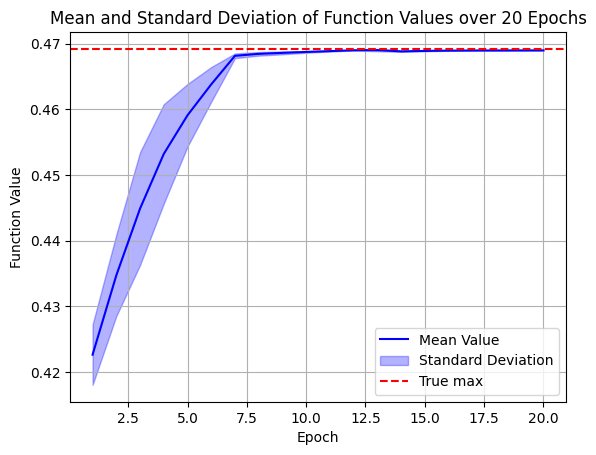

In [291]:

# Calculating the mean and standard deviation across the 5 trajectories
mean_values = trajectoires.mean(axis=0)
std_values = trajectoires.std(axis=0)

# Adding a horizontal dashed red line at the mean of the mean values
#plt.figure(figsize=(10, 6))
epochs = range(1, 21)
plt.plot(epochs, mean_values, label="Mean Value", color="blue", linewidth=1.5)
plt.fill_between(epochs, mean_values - std_values, mean_values + std_values, color="blue", alpha=0.3, label="Standard Deviation")
plt.axhline(y=true_max, color='red', linestyle='--', linewidth=1.5, label="True max")
plt.xlabel("Epoch")
plt.ylabel("Function Value")
plt.title("Mean and Standard Deviation of Function Values over 20 Epochs")
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

